In [1]:
# imports
import pandas as pd

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import json
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# cnn imports
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Flatten, LSTM, Bidirectional, Layer, Input
from tensorflow.python.keras.layers import Input, Dense, Embedding, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing.sequence import pad_sequences

from numpy import array

from datetime import datetime


# Set the randomizer seed so results are the same each time.
np.random.seed(0)

C:\Users\vwang80\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\vwang80\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\vwang80\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\vwang80\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarnin

In [2]:
# Load data
bodies_df = pd.read_csv("train_bodies.csv")
stances_df =  pd.read_csv("train_stances.csv")

# Examine data shape
bodies_df.shape
bodies_df.head()

stances_df.shape
stances_df.head()

stances_df.head()
#combine body and stance tables
combined = pd.concat([stances_df.set_index('Body ID'),bodies_df.set_index('Body ID')], axis=1, join='inner').reset_index()

combined.shape

combined.head()

combined_df_t=combined[['Headline', 'articleBody', 'Stance']]

combined_df_t.head()

# Extract column for just labels
labels_t = combined_df_t['Stance']


In [3]:
# Examine data shape
bodies_df.shape

(1683, 2)

In [4]:
stances_df.shape

(49972, 3)

In [5]:
combined_df_t.head()

,Headline,articleBody,Stance
0,Police find mass graves with at least '15 bodi...,Danny Boyle is directing the untitled film\n\n...,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,Hundreds of Palestinians were evacuated from t...,agree
2,"Christian Bale passes on role of Steve Jobs, a...",30-year-old Moscow resident was hospitalized w...,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,(Reuters) - A Canadian soldier was shot at the...,unrelated
4,Spider burrowed through tourist's stomach and ...,"Fear not arachnophobes, the story of Bunbury's...",disagree


In [6]:
combined_df_t.shape

(49972, 3)

In [7]:
# Drop columns that are strings
all_data_processed = combined_df_t.drop(['Stance'], axis=1)
#all_data_processed = combined_df_t.drop(['articleBody'], axis=1)

In [8]:
new_labels1= labels_t.copy()

new_labels1[new_labels1=='agree']=2
new_labels1[new_labels1=='unrelated']=1
new_labels1[new_labels1=='disagree']=0
new_labels1[new_labels1=='discuss']=1


In [9]:
new_labels1

0        1
1        2
2        1
3        1
4        0
        ..
49967    1
49968    1
49969    2
49970    1
49971    1
Name: Stance, Length: 49972, dtype: object

In [10]:
sum(new_labels1)/len(new_labels1)

1.0567918034099095

In [11]:
all_data_processed.head()

,Headline,articleBody
0,Police find mass graves with at least '15 bodi...,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,"Fear not arachnophobes, the story of Bunbury's..."


In [12]:
# Set some variables to hold test, dev, and training data.
test_data, test_labels = all_data_processed[:1000], new_labels1[:1000]
dev_data, dev_labels = all_data_processed[1001:3000], new_labels1[1001:3000]
train_data, train_labels = all_data_processed[3001:], new_labels1[3001:]

In [13]:
len(test_data)

1000

In [14]:
len(train_data)

46971

In [15]:
# Used GLoVE embeddings
embeddings_dict = {}
with open("glove.6B.50d.txt", 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        token = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[token] = vector

In [16]:
def sent_to_ids(sentences):
    """
    converting a list of strings to a list of lists of word ids
    """
    
    # TODO - Update Regular Expression for parsing (TINA)
    # Improvement Option (Remove trailing 's') Check Missing list for optimization
    
    #re.sub('[^A-Za-z0-9]+', '', mystring)
    #cleanString = re.sub('\W+','', string ) 
    
    bad_chars = [';', ':', '!', "*"] 
    
    text_ids = []
    example = []
    sentences = sentences.replace('.','')
    sentences = sentences.replace('\'','')
    sentences = sentences.replace(',','')
    sentences = sentences.replace('$','')
    sentences = sentences.replace('/',' ')
    sentences = sentences.replace('','')
    for word in sentences.split(' '):
        #word.lower()
        temp = word.lower()
        #temp.replace('\'','')
        if temp in embeddings_dict:
            example.append(embeddings_dict[temp])
        else:
            print("Missing ", temp)            
    text_ids.append(example)

    return  text_ids   

In [17]:
all_data_emb = all_data_processed.copy()

In [18]:
all_data_processed['Headline'][1]

'Hundreds of Palestinians flee floods in Gaza as Israel opens dams'

In [19]:
train_data

,Headline,articleBody
3001,Jihadi John ‘identified as British man from We...,Some iPhone 6 users say they are literally pul...
3002,Dog abandoned at Scotland train station with s...,Offers have been pouring in to re-home a dog f...
3003,The Man Who Says Comcast Got Him Fired Has Fil...,A photo provided by the Nicaraguan Army shows ...
3004,Iraqi media says ISIS militants have contracte...,It's what national security organizations have...
3005,An accidental delivery of arms to the Islamic ...,We're just two months away from the Apple Watc...
...,...,...
49967,Urgent: The Leader of ISIL 'Abu Bakr al-Baghda...,(CNN) -- Boko Haram laughed off Nigeria's anno...
49968,Brian Williams slams social media for speculat...,Along with unveiling the Apple Watch earlier t...
49969,Mexico Says Missing Students Not Found In Firs...,The bodies found in a mass grave were confirme...
49970,US Lawmaker: Ten ISIS Fighters Have Been Appre...,Rep. Duncan Hunter (R-CA) told Greta Van Suste...


In [20]:
all_data_token = combined_df_t['Headline']+combined_df_t['articleBody']

In [21]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(all_data_token)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(test_data)
#print(encoded_docs)

In [22]:
embeddings_index_ex = dict()
with open("glove.6B.50d.txt", 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index_ex[word] = coefs
#    f.close()
print('Loaded %s word vectors.' % len(embeddings_index_ex))

Loaded 400000 word vectors.


In [23]:
# create a weight matrix for words in training docs
embedding_matrix_ex = np.zeros((vocab_size, 50))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index_ex.get(word)
    if embedding_vector is not None:
        embedding_matrix_ex[i] = embedding_vector

In [24]:
# This is a hepler method to display and plot results
def showResults(history):
    val_acc = np.array(history.history['val_main_output_acc'])
    train_ac = np.array(history.history['main_output_acc'])
    print("Best validation Accuracy: %.4f" % max(val_acc))
    print("Best train Accuracy: %.4f" %  max(train_ac))

    plt.figure(figsize=(14, 4))
    ax = plt.subplot(121)

    # Plot Loss Vs Epoch for Train and validation Sets
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot( [i + 1 for i in range(len(history.history['loss']))], history.history['loss'],  '-gD', marker='o', label="Training loss")
    plt.plot( [i + 1 for i in range(len(history.history['val_loss']))], history.history['val_loss'],  '-bD', marker='o', label="Validation loss")
    plt.legend(loc="best")

    # Plot Accuracy Vs Epoch for Train and validation Sets
    ax = plt.subplot(122)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.plot( [i + 1 for i in range(len(history.history['main_output_acc']))], history.history['main_output_acc'],  '-gD', marker='o', label="Train Accuracy")
    plt.plot( [i + 1 for i in range(len(history.history['val_main_output_acc']))], history.history['val_main_output_acc'],  '-bD', marker='o', label="Validation Accuracy")
    plt.legend(loc="best")

In [25]:
def encodeDoc(data, size):
# integer encode the documents
#encoded_docs = t.texts_to_sequences(all_data_processed['Headline'])
#encoded_docs = t.texts_to_sequences(train_data)
    encoded_docs = t.texts_to_sequences(data)

    #print(encoded_docs)
    # pad documents to a max length of 4 words
    max_length = size
    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
    #print(padded_docs)
    
    return padded_docs

In [26]:
padded_docs_h = encodeDoc(dev_data['Headline'],10)
padded_docs_b = encodeDoc(dev_data['articleBody'], 35)
padded_test_docs_h = encodeDoc(test_data['Headline'],10)
padded_test_docs_b = encodeDoc(test_data['articleBody'], 35)


In [27]:
# Note that we can name any layer by passing it a "name" argument.
headline_input = Input(shape=(10,), dtype='int32', name='headline_input')

# This embedding layer will encode the input sequence
# into a sequence of dense 512-dimensional vectors.
emb_h = Embedding(vocab_size, 50, weights=[embedding_matrix_ex], input_length=10, trainable=False)(headline_input)

# A LSTM will transform the vector sequence into a single vector,
# containing information about the entire sequence
lstm_out_h = LSTM(32)(emb_h)
headline_out = Dense(1, activation='sigmoid', name='headline_out')(lstm_out_h)

Instructions for updating:
Colocations handled automatically by placer.


In [28]:
# Note that we can name any layer by passing it a "name" argument.
body_input = Input(shape=(35,), dtype='int32', name='body_input')

# This embedding layer will encode the input sequence
# into a sequence of dense 512-dimensional vectors.
emb_b = Embedding(vocab_size, 50, weights=[embedding_matrix_ex], input_length=35, trainable=False)(body_input)

# A LSTM will transform the vector sequence into a single vector,
# containing information about the entire sequence
lstm_out_b = LSTM(32)(emb_b)
body_out = Dense(1, activation='sigmoid', name='body_out')(lstm_out_b)

In [29]:
#x = keras.layers.concatenate([headline_out, body_out])
conc = tf.keras.layers.concatenate([headline_out, body_out])

# We stack a deep densely-connected network on top
x = Dense(64, activation='relu')(conc)
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)

# And finally we add the main logistic regression layer
main_output = Dense(1, activation='sigmoid', name='main_output')(x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [30]:
model5 = Model(inputs=[headline_input, body_input], outputs=[main_output, headline_out, body_out ])

In [31]:
model5.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [32]:
# fit the model
batch_size = 30
history = model5.fit([padded_docs_h, padded_docs_b], [dev_labels,dev_labels,dev_labels], batch_size=batch_size, epochs=80, validation_split= 0.2)

Train on 1599 samples, validate on 400 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/80
1599/1599 [==============================] - 6s 4ms/sample - loss: 0.4203 - main_output_loss: 0.1828 - headline_out_loss: 0.1393 - body_out_loss: 0.0982 - main_output_acc: 0.8968 - headline_out_acc: 0.8856 - body_out_acc: 0.8737 - val_loss: -0.6006 - val_main_output_loss: -0.2365 - val_headline_out_loss: -0.1663 - val_body_out_loss: -0.1979 - val_main_output_acc: 0.9150 - val_headline_out_acc: 0.9100 - val_body_out_acc: 0.9150
Epoch 2/80
1599/1599 [==============================] - 4s 3ms/sample - loss: -0.9396 - main_output_loss: -0.4235 - headline_out_loss: -0.2622 - body_out_loss: -0.2538 - main_output_acc: 0.9131 - headline_out_acc: 0.9118 - body_out_acc: 0.9131 - val_loss: -1.6839 - val_main_output_loss: -0.8768 - val_headline_out_loss: -0.4204 - val_body_out_loss: -0.3866 - val_main_output_acc: 0.9150 - val_headline_out_acc: 0.9125 - val_body_out_acc: 0.9150
Epoch 3/80
1599/1

Epoch 19/80
1599/1599 [==============================] - 4s 3ms/sample - loss: -2.5946 - main_output_loss: -0.8763 - headline_out_loss: -0.9107 - body_out_loss: -0.8076 - main_output_acc: 0.9137 - headline_out_acc: 0.9149 - body_out_acc: 0.9131 - val_loss: -2.6678 - val_main_output_loss: -0.9048 - val_headline_out_loss: -0.8862 - val_body_out_loss: -0.8768 - val_main_output_acc: 0.9100 - val_headline_out_acc: 0.9150 - val_body_out_acc: 0.9150
Epoch 20/80
1599/1599 [==============================] - 4s 3ms/sample - loss: -2.6031 - main_output_loss: -0.8855 - headline_out_loss: -0.9100 - body_out_loss: -0.8076 - main_output_acc: 0.9112 - headline_out_acc: 0.9131 - body_out_acc: 0.9131 - val_loss: -2.6878 - val_main_output_loss: -0.9088 - val_headline_out_loss: -0.9021 - val_body_out_loss: -0.8768 - val_main_output_acc: 0.9150 - val_headline_out_acc: 0.9100 - val_body_out_acc: 0.9150
Epoch 21/80
1599/1599 [==============================] - 4s 3ms/sample - loss: -2.6216 - main_output_loss:

1599/1599 [==============================] - 4s 3ms/sample - loss: -2.7010 - main_output_loss: -0.9402 - headline_out_loss: -0.9532 - body_out_loss: -0.8076 - main_output_acc: 0.9118 - headline_out_acc: 0.9156 - body_out_acc: 0.9131 - val_loss: -2.6375 - val_main_output_loss: -0.8986 - val_headline_out_loss: -0.8621 - val_body_out_loss: -0.8768 - val_main_output_acc: 0.9000 - val_headline_out_acc: 0.9025 - val_body_out_acc: 0.9150
Epoch 38/80
1599/1599 [==============================] - 4s 3ms/sample - loss: -2.7101 - main_output_loss: -0.9457 - headline_out_loss: -0.9568 - body_out_loss: -0.8076 - main_output_acc: 0.9156 - headline_out_acc: 0.9156 - body_out_acc: 0.9131 - val_loss: -2.6447 - val_main_output_loss: -0.8989 - val_headline_out_loss: -0.8689 - val_body_out_loss: -0.8768 - val_main_output_acc: 0.9000 - val_headline_out_acc: 0.9025 - val_body_out_acc: 0.9150
Epoch 39/80
1599/1599 [==============================] - 4s 3ms/sample - loss: -2.7097 - main_output_loss: -0.9437 - h

1599/1599 [==============================] - 4s 3ms/sample - loss: -2.7311 - main_output_loss: -0.9607 - headline_out_loss: -0.9628 - body_out_loss: -0.8076 - main_output_acc: 0.9156 - headline_out_acc: 0.9156 - body_out_acc: 0.9131 - val_loss: -2.6533 - val_main_output_loss: -0.9032 - val_headline_out_loss: -0.8733 - val_body_out_loss: -0.8768 - val_main_output_acc: 0.9100 - val_headline_out_acc: 0.9025 - val_body_out_acc: 0.9150
Epoch 56/80
1599/1599 [==============================] - 4s 3ms/sample - loss: -2.7317 - main_output_loss: -0.9612 - headline_out_loss: -0.9630 - body_out_loss: -0.8076 - main_output_acc: 0.9137 - headline_out_acc: 0.9156 - body_out_acc: 0.9131 - val_loss: -2.6590 - val_main_output_loss: -0.9048 - val_headline_out_loss: -0.8774 - val_body_out_loss: -0.8768 - val_main_output_acc: 0.9075 - val_headline_out_acc: 0.9075 - val_body_out_acc: 0.9150
Epoch 57/80
1599/1599 [==============================] - 4s 3ms/sample - loss: -2.7324 - main_output_loss: -0.9616 - h

1599/1599 [==============================] - 5s 3ms/sample - loss: -2.7345 - main_output_loss: -0.9623 - headline_out_loss: -0.9646 - body_out_loss: -0.8076 - main_output_acc: 0.9143 - headline_out_acc: 0.9162 - body_out_acc: 0.9131 - val_loss: -2.6656 - val_main_output_loss: -0.9030 - val_headline_out_loss: -0.8857 - val_body_out_loss: -0.8768 - val_main_output_acc: 0.9075 - val_headline_out_acc: 0.9075 - val_body_out_acc: 0.9150
Epoch 74/80
1599/1599 [==============================] - 5s 3ms/sample - loss: -2.7299 - main_output_loss: -0.9584 - headline_out_loss: -0.9639 - body_out_loss: -0.8076 - main_output_acc: 0.9124 - headline_out_acc: 0.9156 - body_out_acc: 0.9131 - val_loss: -2.6625 - val_main_output_loss: -0.9014 - val_headline_out_loss: -0.8842 - val_body_out_loss: -0.8768 - val_main_output_acc: 0.9025 - val_headline_out_acc: 0.9075 - val_body_out_acc: 0.9150
Epoch 75/80
1599/1599 [==============================] - 5s 3ms/sample - loss: -2.7302 - main_output_loss: -0.9582 - h

In [33]:
# evaluate the model
accuracy = model5.evaluate([padded_test_docs_h,padded_test_docs_b], [test_labels,test_labels,test_labels], verbose=1)
print('Loss: %f' % (accuracy[0]))
print('Combined Loss: %f' % (accuracy[1]))
print('Headline Loss: %f' % (accuracy[2]))
print('Body Loss: %f' % (accuracy[3]))
print('Accuracy: %f' % (accuracy[4]))
print('Headline Accuracy: %f' % (accuracy[5]))
print('Body Accuracy: %f' % (accuracy[6]))

1000/1000 [==============================] - 1s 1ms/sample - loss: -3.3740 - main_output_loss: -1.1305 - headline_out_loss: -1.0797 - body_out_loss: -1.1638 - main_output_acc: 0.8830 - headline_out_acc: 0.8870 - body_out_acc: 0.8930
Loss: -3.373960
Combined Loss: -1.130455
Headline Loss: -1.079712
Body Loss: -1.163794
Accuracy: 0.883000
Headline Accuracy: 0.887000
Body Accuracy: 0.893000


Best validation Accuracy: 0.9150
Best train Accuracy: 0.9168


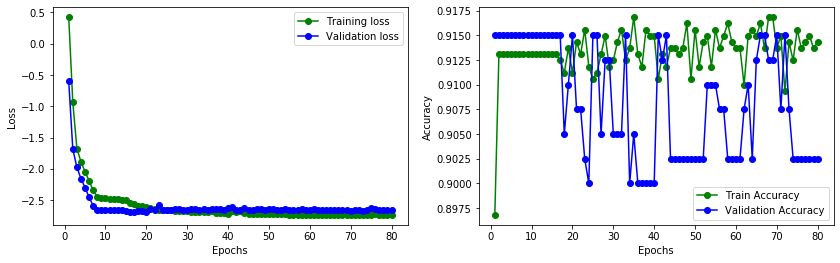

In [34]:
showResults(history)